Import library *

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, UpSampling2D, Input, Reshape

from keras import backend as K
import itertools
import tensorflow 
from keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.optimizers import Adam

#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [7]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Map dataset

In [8]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [9]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
print(skin_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')


Preview dataset

In [11]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\input/skin-cancer-mnist-ham10000\HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\input/skin-cancer-mnist-ham10000\HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\input/skin-cancer-mnist-ham10000\HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\input/skin-cancer-mnist-ham10000\HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\input/skin-cancer-mnist-ham10000\HAM10000_i...,Benign keratosis-like lesions,2


### Data cleaning
Remove null values

In [12]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


Distribution of the 7 different classes of cell types

<AxesSubplot:>

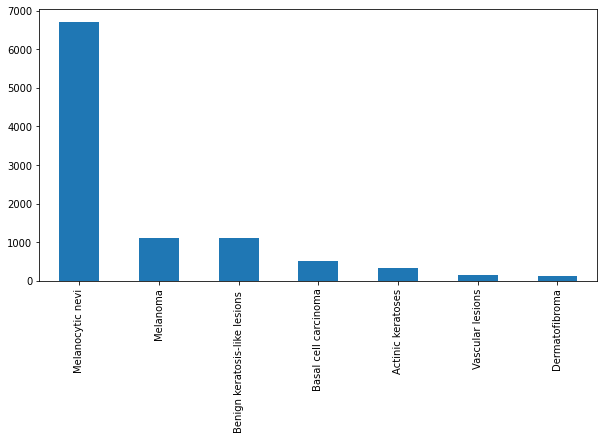

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Results reveal an imbalanced dataset. Applying downsampling 

In [14]:
from sklearn.utils import resample

samples_count = skin_df['cell_type'].value_counts()
majority_class = skin_df['cell_type'].isin([samples_count.idxmax()])
minority_class = skin_df['cell_type'].isin([samples_count.idxmin()])

df_majority = skin_df[majority_class]
df_minority = skin_df[minority_class]

print(skin_df['cell_type'].value_counts().idxmax())

Melanocytic nevi


<AxesSubplot:title={'center':'Count'}>

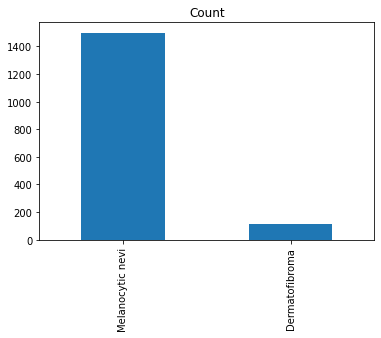

In [15]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=1500,    # to match minority class
                                 random_state=123)  # reproducible results
# Combine majority class with downsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled['cell_type'].value_counts().plot(kind='bar', title='Count')

<AxesSubplot:title={'center':'Count'}>

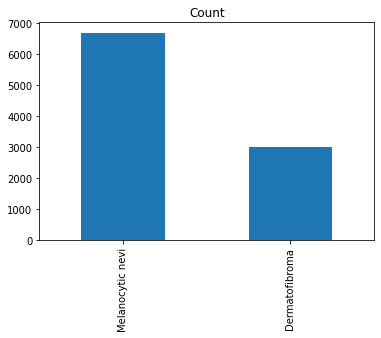

In [16]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=3000,    # to match majority class
                                 random_state=42)   # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled['cell_type'].value_counts().plot(kind='bar', title='Count')

In [17]:
skin_df = skin_df[skin_df['cell_type'] != skin_df['cell_type'].value_counts().idxmax()]
skin_df = pd.concat([skin_df, df_majority_downsampled], sort=True)
print(skin_df['cell_type'].value_counts())

Melanocytic nevi                  1500
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


## Resampled Dataset

<AxesSubplot:>

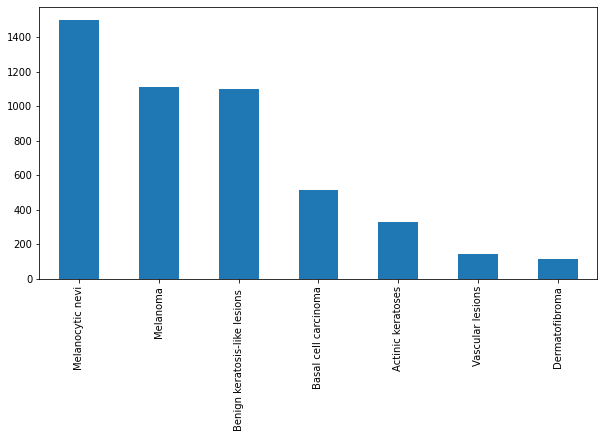

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

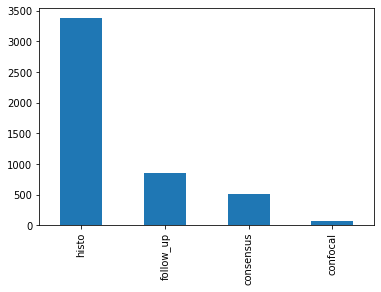

In [19]:
skin_df['dx_type'].value_counts().plot(kind='bar')

Plotting the distribution of localization field

<AxesSubplot:>

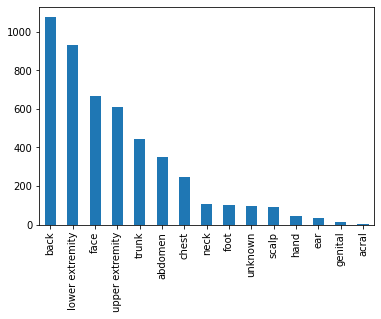

In [20]:
skin_df['localization'].value_counts().plot(kind='bar')

Distribution of Age

<AxesSubplot:>

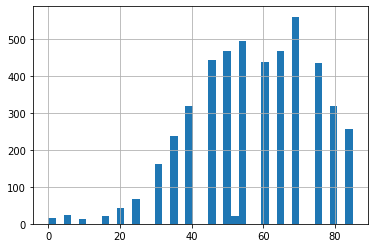

In [21]:
skin_df['age'].hist(bins=40)

Distribution of gender

<AxesSubplot:>

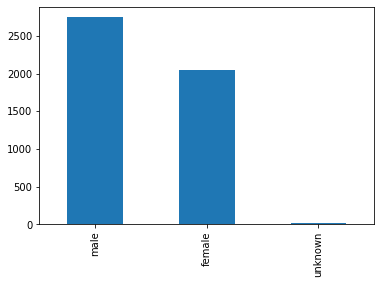

In [22]:
skin_df['sex'].value_counts().plot(kind='bar')

Distribution of cancer type and age

c:\Users\ghars\Downloads\CS200\env3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='cell_type_idx'>

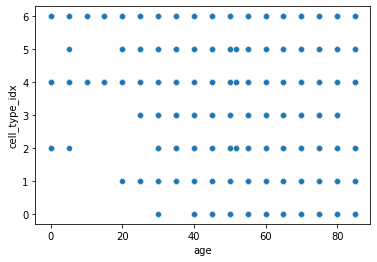

In [23]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

### Resize images

In [24]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,96))))

Display sample images of each cancer type

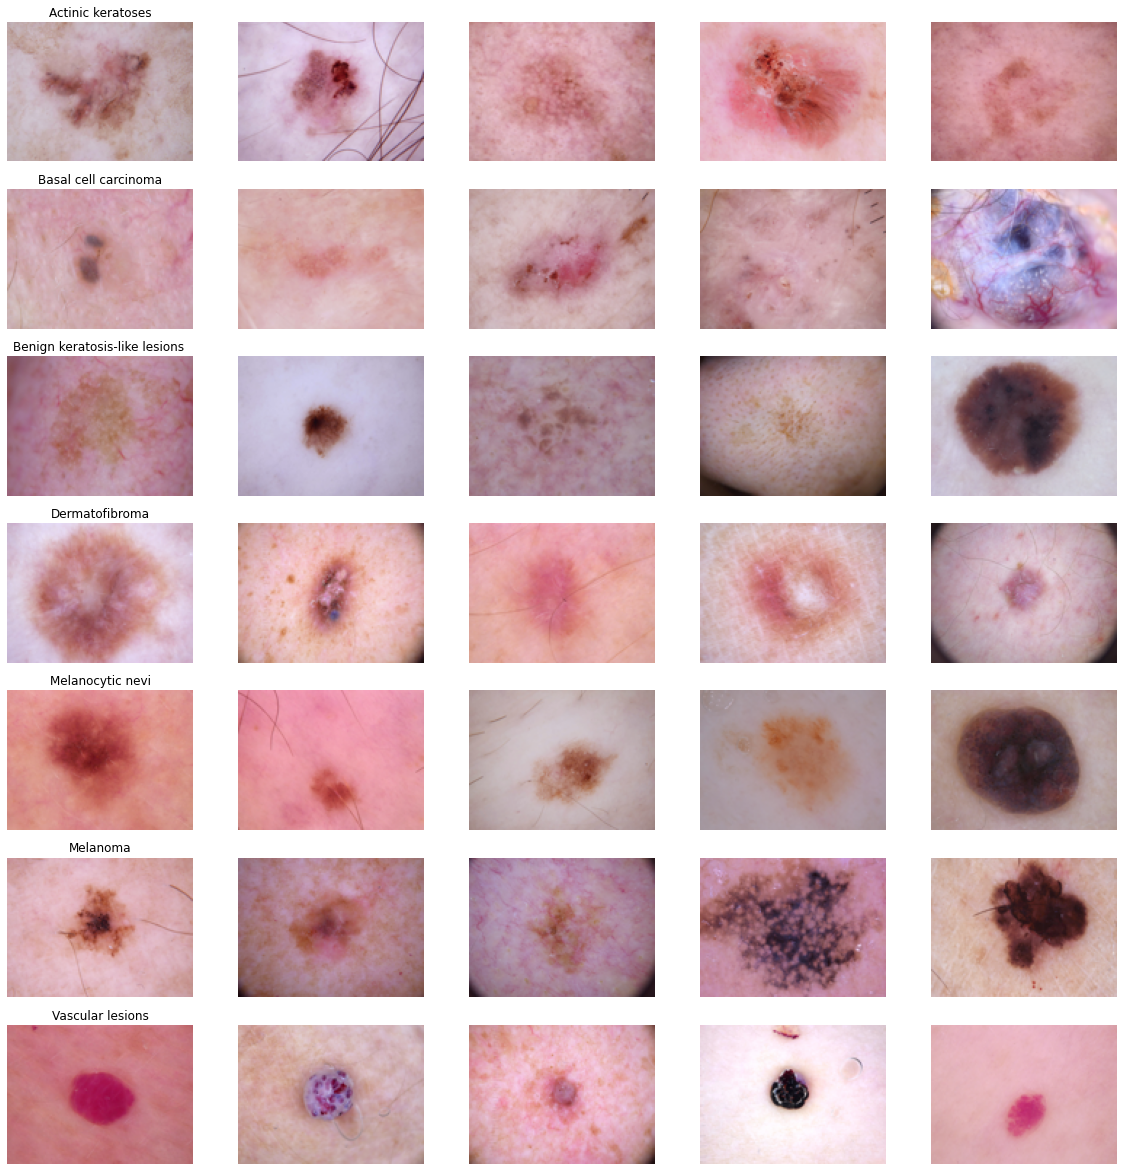

In [25]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [26]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(96, 128, 3)    4810
Name: image, dtype: int64

### Set features and target

In [27]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

### Split training set 90/10

In [28]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.10,random_state=1234)

### Normalization

In [29]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

### Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6

In [30]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

### Split training and validation split
Training (70%)
Validation (30%)

In [31]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

### Reshape images into 3 dimensions

In [32]:
x_train = x_train.reshape(x_train.shape[0], *(96, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 128, 3))

In [33]:
print(np.bincount(skin_df['cell_type_idx']))

[ 327  514 1099  115 1500 1113  142]


# VGG16 + ResNet50 Classifier

![](https://camo.qiitausercontent.com/41d1c56410a73bd3510ee7df57b854001ae66d2b/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136363334352f38363836656331622d303534362d633266362d396332652d3535343633646635643165662e706e67)

In [82]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow

from keras.applications.vgg16 import VGG16




def vgg16(epochs, batch_size, classes, model_input):
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    # add Dropout layer to reduce overfitting
    x = Dropout(0.2)(x)
    # and a logistic layer
    predictions = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False

    sgd =tensorflow.keras.optimizers.SGD(lr=0.01, clipvalue=0.5)
    model.compile(optimizer= sgd , loss='categorical_crossentropy', metrics=['accuracy'])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

    # train 
    history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  class_weight=class_weights,
                                  epochs = epochs, validation_data = (x_validate,y_validate),
                                  verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=callbacks)

    return model, history

In [83]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.applications import resnet

from keras.models import Model



def resnet50(epochs, batch_size, classes, model_input):
    # create the base pre-trained model
    
    model_input = Input(shape=(96, 128, 3)) 
    base_model = resnet.ResNet50 (weights='imagenet', include_top=False, input_tensor=model_input)
    x = base_model.output 
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
    
    # train 
    history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  class_weight=class_weights,
                                  epochs = epochs, validation_data = (x_validate,y_validate),
                                  verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=callbacks)

    return model, history

Learning rate reduction *

In [84]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

callbacks = [learning_rate_reduction, checkpoint, early]

Data Augmentation

In [87]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [88]:
total = 0
class_weights = []
for i in skin_df['cell_type'].value_counts():
    total += i
class_weights = [1 - (i/total) for i in skin_df['cell_type'].value_counts()]

# Fit the models

In [ ]:
epochs = 100
batch_size = 10
classes = 7

model_input = Input(shape=(96, 128, 3))
vgg16_model, history = vgg16(epochs, batch_size, classes, model_input)


In [ ]:
resnet50_model, resnet50_history = resnet50(epochs, batch_size, classes, model_input)

In [41]:
for i, layer in enumerate(vgg16_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1
21 dropout_1
22 dense_2


## Freeze all layers except FC and Dense Layer

In [42]:
# the first 249 layers and unfreeze the rest:
for layer in vgg16_model.layers[:-2]:
   layer.trainable = False
for layer in vgg16_model.layers[-2:]:
   layer.trainable = True

In [43]:
# we use SGD with a low learning rate
from keras.optimizers import SGD
vgg16_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

## Fine-Tune Top 2 Layers

In [44]:
vgg16_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size))

Epoch 1/1
390/390 [==============================] - 13s 32ms/step - loss: 0.9912 - accuracy: 0.6111


# Models Evaluation

In [ ]:
loss, accuracy = vgg16_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = vgg16_model.evaluate(x_validate, y_validate, verbose=1)
print("VGG16")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

In [ ]:
loss, accuracy = resnet50_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = resnet50_model.evaluate(x_validate, y_validate, verbose=1)
print("ResNet50")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

### VGG16 Training Results

In [ ]:
plot_model_history(history)

### ResNet50 Training Results

In [ ]:
plot_model_history(resnet50_history)

### Ensemble CNN (VGG16 + ResNet50)

In [49]:
from keras.layers import Average

ensembled_models = [vgg16_model, resnet50_model]
outputs = Average()([m.outputs[0] for m in ensembled_models])
ensemble_model = Model(model_input, outputs, name='ensemble')
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
ensemble_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
loss, accuracy = ensemble_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = ensemble_model.evaluate(x_validate, y_validate, verbose=1)
print("Ensemble")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = ensemble_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Incorrect predictions

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Save models

In [78]:
vgg16_model.save('vgg16_weights')
resnet50_model.save('resnet50_weights')
ensemble_model.save('ensemble_classifier')

In [82]:

vgg16_model.save('vgg16_model.h5')
resnet50_model.save('resnet50_model.h5')
ensemble_model.save('ensemble_model.h5')


In [95]:
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 128, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 128, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 128, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 32, 128)       0   

In [96]:
resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [97]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [98]:
vgg16_model.save_weights('vgg16_model.h5')

In [99]:
resnet50_model.save_weights('resnet50_model.h5')

In [100]:
ensemble_model.save_weights('ensemble_model.h5')

Test

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

labels = ['BKL', 'BCC', 'BF', 'AKIEC', 'MEL', 'NV', 'VASC']

img = image.load_img('../input/ham1000-segmentation-and-classification/images/ISIC_0027419.jpg',target_size=( 224, 224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = tf.keras.models.load_model("ensemble_model.h5")
output = vgg16_model.predict(img)

output
print(output)

arr = np.max(output)
result = np.where(output == np.amax(output))
print(arr)
print(result)
max = np.argmax(output)
print(max)

labels[max]